In [2]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from seaborn import heatmap

In [3]:
from math import sqrt

In [4]:



from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

# acquire

In [5]:
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

# prepare

In [6]:
df.head(1)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [7]:
# clean data
df.columns = [col.lower() for col in df]

In [8]:
# rename
df = df.rename(columns= {'dt':'datetime','AverageTemperature':'avg_temp',"averagetemperatureuncertainty":'uncertainty'})
df = df.drop(columns= ['latitude','longitude','country'])

In [9]:
df

,datetime,averagetemperature,uncertainty,city
0,1849-01-01,26.704,1.435,Abidjan
1,1849-02-01,27.434,1.362,Abidjan
2,1849-03-01,28.101,1.612,Abidjan
3,1849-04-01,26.140,1.387,Abidjan
4,1849-05-01,25.427,1.200,Abidjan
...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian
239173,2013-06-01,23.522,0.647,Xian
239174,2013-07-01,25.251,1.042,Xian
239175,2013-08-01,24.528,0.840,Xian


In [10]:
df.datetime = pd.to_datetime(df.datetime)

In [11]:
df = df.set_index('datetime').sort_values(by = 'datetime')

In [12]:
dfc = df[df.city == 'Chicago'] 
dfc = dfc.drop(columns= ['city'])

In [13]:
dfc.isnull().value_counts()

averagetemperature  uncertainty
False               False          3141
True                True             98
dtype: int64

In [14]:
dfc.shape

(3239, 2)

In [15]:
print('Number of rows:', df.index.nunique())
n_days = df.index.max() - df.index.min() + pd.Timedelta('1d')
print(f"Number of days between first and last day:", n_days)


Number of rows: 3239
Number of days between first and last day: 98556 days 00:00:00


In [16]:
dfc.index.max()

Timestamp('2013-09-01 00:00:00')

In [17]:
dfc.index.min()

Timestamp('1743-11-01 00:00:00')

In [18]:
# dfc = dfc.dropna()

<div class="alert alert-block alert-info">
<b>Take Aways:</b> I dropped 98 nulls, i think i want to forecast the next two weeks temperatures, using data from 1980 to 2013, 2013 being my test data.


In [19]:
dfc = dfc['1960':]

In [20]:
print('Number of rows:', dfc.index.nunique())
n_days = dfc.index.max() - dfc.index.min() + pd.Timedelta('1d')
print(f"Number of days between first and last day:", n_days)


Number of rows: 645
Number of days between first and last day: 19603 days 00:00:00


In [21]:
dfc

,averagetemperature,uncertainty
datetime,,
1960-01-01,1.402,0.257
1960-02-01,-0.008,0.293
1960-03-01,-2.318,0.369
1960-04-01,9.149,0.260
1960-05-01,10.803,0.363
...,...,...
2013-05-01,13.734,0.863
2013-06-01,17.913,0.669
2013-07-01,21.914,0.322


In [22]:
# rename
dfc = dfc.rename(columns= {'averagetemperature':'avg_temp'})
dfc = dfc.rename(columns= {'averagetemperatureuncertainty':'uncertainty'})

<AxesSubplot:xlabel='datetime'>

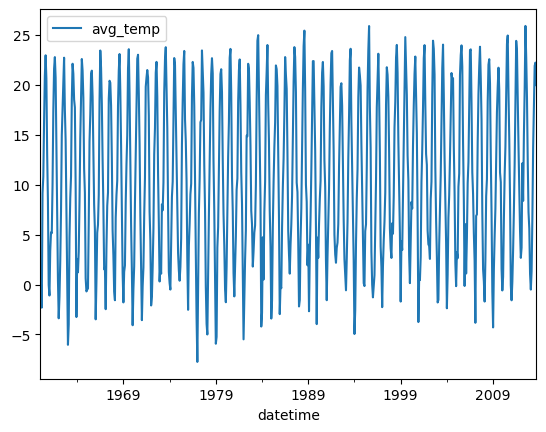

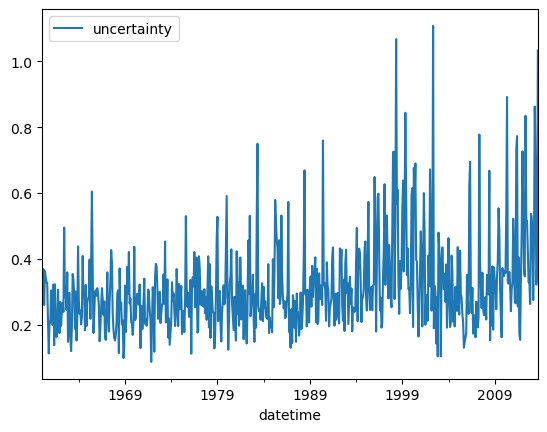

In [23]:
dfc.plot(y = "avg_temp")
dfc.plot(y = "uncertainty")

<div class="alert alert-block alert-info">
<b>Take Aways:</b> it looks like `avg_temp` and `uncertainty` are both rising gradually

In [24]:
print('Number of rows:', dfc.index.nunique())
n_days = dfc.index.max() - dfc.index.min() + pd.Timedelta('1d')
print(f"Number of days between first and last day:", n_days)

Number of rows: 645
Number of days between first and last day: 19603 days 00:00:00


In [25]:
dfc.index.max(),dfc.index.min()

(Timestamp('2013-09-01 00:00:00'), Timestamp('1960-01-01 00:00:00'))

# percentage-based split

In [26]:
train_size = int(len(dfc) * .5)
validate_size = int(len(dfc) * .3)
test_size = int(len(dfc) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = dfc[: train_size]
validate = dfc[train_size : validate_end_index]
test = dfc[validate_end_index : ]

In [27]:
train

,avg_temp,uncertainty
datetime,,
1960-01-01,1.402,0.257
1960-02-01,-0.008,0.293
1960-03-01,-2.318,0.369
1960-04-01,9.149,0.260
1960-05-01,10.803,0.363
...,...,...
1986-06-01,17.106,0.228
1986-07-01,22.787,0.270
1986-08-01,21.012,0.295


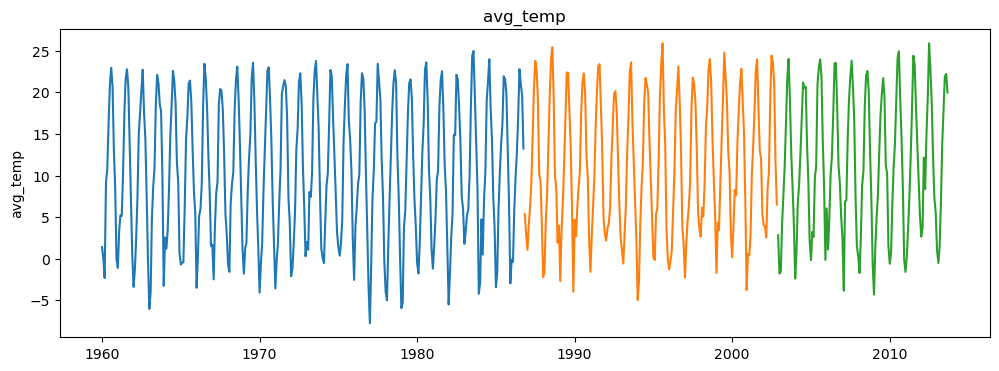

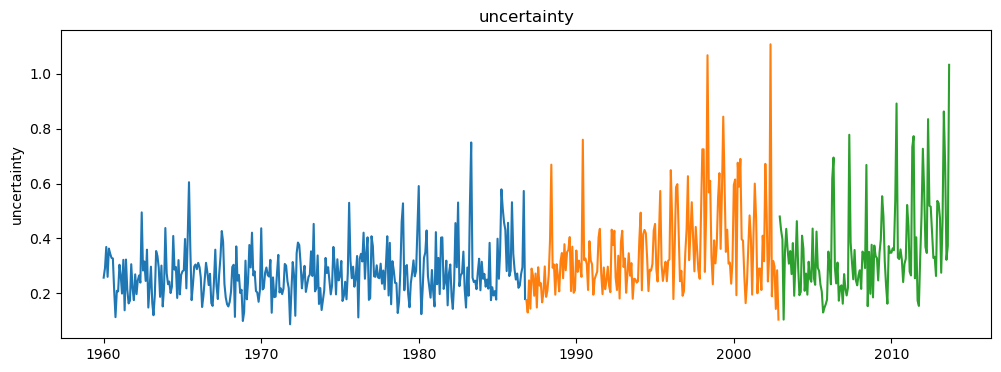

In [28]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# visuals

In [29]:
y = train['avg_temp']

<AxesSubplot:ylabel='Frequency'>

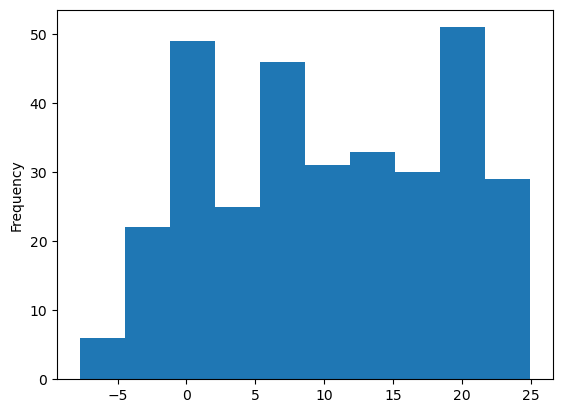

In [30]:
y.plot.hist()


<div class="alert alert-block alert-info">
<b>Take Aways:</b> alot of cold days.. 25 celsius or 75 has very occasions than 5 c

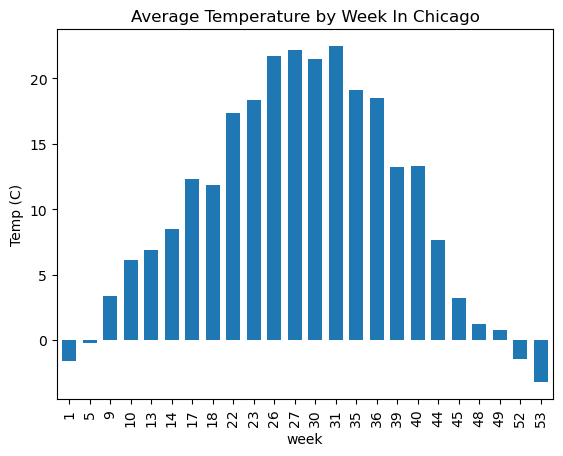

In [31]:
ax = y.groupby(y.index.week).mean().plot.bar(width = .7)
ax.set(title='Average Temperature by Week In Chicago', xlabel='week', ylabel='Temp (C)')
None

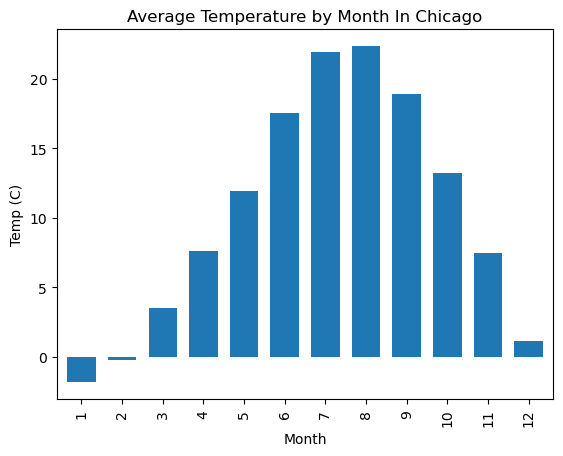

In [32]:
ax = y.groupby(y.index.month).mean().plot.bar(width = .7)
ax.set(title='Average Temperature by Month In Chicago', xlabel='Month', ylabel='Temp (C)')
None



# over time

<AxesSubplot:xlabel='datetime'>

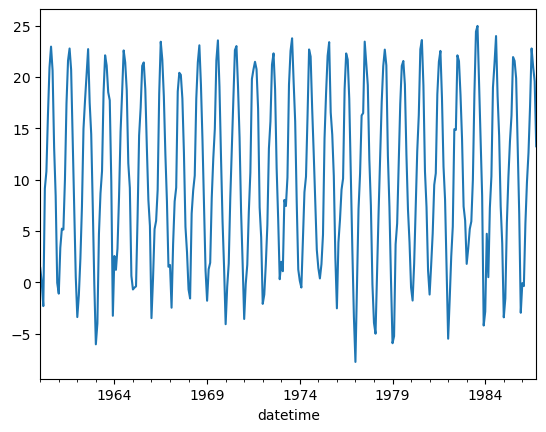

In [33]:
y.plot()

In [34]:
dfc['wok'] = dfc.index.strftime('%a') 
dfc['mon'] = dfc.index.strftime('%b') 

## resample

In [35]:
y

datetime
1960-01-01     1.402
1960-02-01    -0.008
1960-03-01    -2.318
1960-04-01     9.149
1960-05-01    10.803
               ...  
1986-06-01    17.106
1986-07-01    22.787
1986-08-01    21.012
1986-09-01    19.599
1986-10-01    13.254
Name: avg_temp, Length: 322, dtype: float64

<AxesSubplot:title={'center':'1 Month Average'}, xlabel='datetime'>

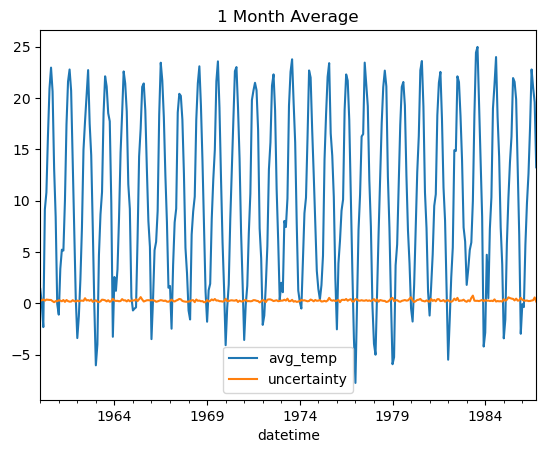

In [36]:
train.resample('m').mean().plot(title='1 Month Average')


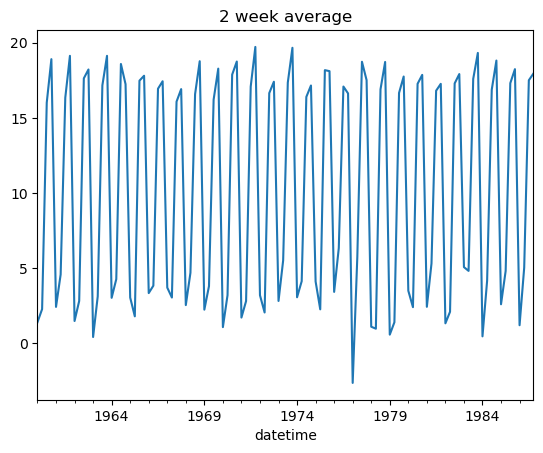

In [37]:
y.resample('3m').mean().plot(title='2 week average')
None

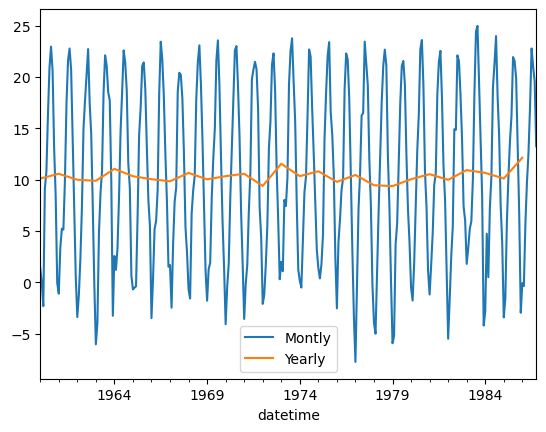

In [38]:
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()
None

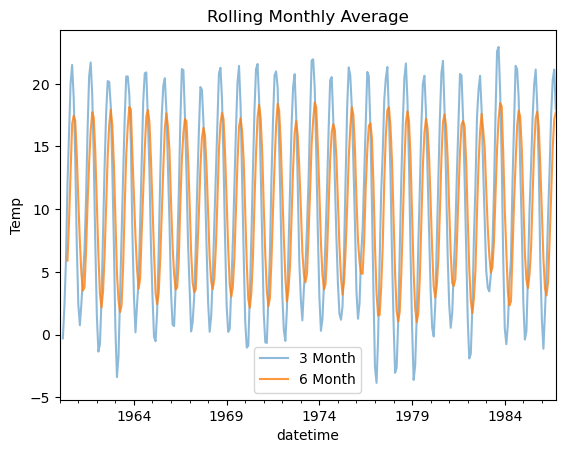

In [39]:
y.resample('M').mean().rolling(3).mean().plot(alpha=.5, label='3 Month')
y.resample('M').mean().rolling(6).mean().plot(alpha=.8, label='6 Month')
plt.title ('Rolling Monthly Average')
plt.ylabel('Temp')
plt.legend()

None


# Last Observed Values

In [40]:
train

,avg_temp,uncertainty
datetime,,
1960-01-01,1.402,0.257
1960-02-01,-0.008,0.293
1960-03-01,-2.318,0.369
1960-04-01,9.149,0.260
1960-05-01,10.803,0.363
...,...,...
1986-06-01,17.106,0.228
1986-07-01,22.787,0.270
1986-08-01,21.012,0.295


In [41]:
avg_temp = train['avg_temp'][-1:][0]
uncertainty = train['uncertainty'][-1:][0]

# functions to help

In [42]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])


In [43]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [44]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [45]:
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


# prediction table

In [46]:
yhat_df = pd.DataFrame({'avg_temp': [avg_temp], 'uncertainty': [uncertainty]}, 
                       index = validate.index)

yhat_df.head(2)

,avg_temp,uncertainty
datetime,,
1986-11-01,13.254,0.179
1986-12-01,13.254,0.179


['avg_temp', 'uncertainty'] -- RMSE: 6


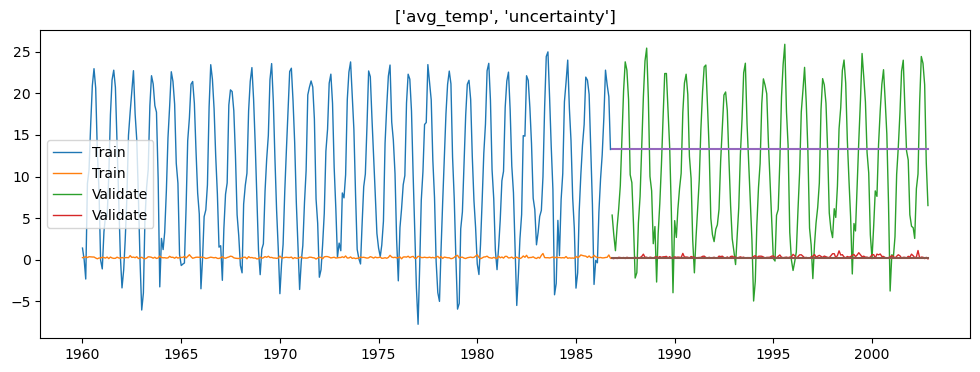

In [47]:
 plot_and_eval(['avg_temp','uncertainty'])

# eval

In [48]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [49]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,uncertainty,0.0


# simple average

In [50]:
avg_temp = round(train['avg_temp'].mean(),2)
uncertainty = round(train['uncertainty'].mean(),2)

In [51]:
yhat_df = pd.DataFrame({'avg_temp': [avg_temp],
                            'uncertainty': [uncertainty],
                           }, index = validate.index)

In [52]:
yhat_df.head(1)

,avg_temp,uncertainty
datetime,,
1986-11-01,10.33,0.27


# actual vs predict values

avg_temp -- RMSE: 8


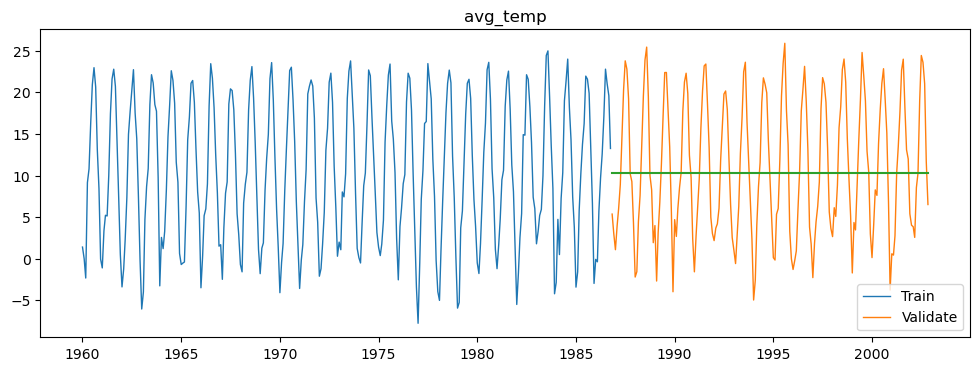

uncertainty -- RMSE: 0


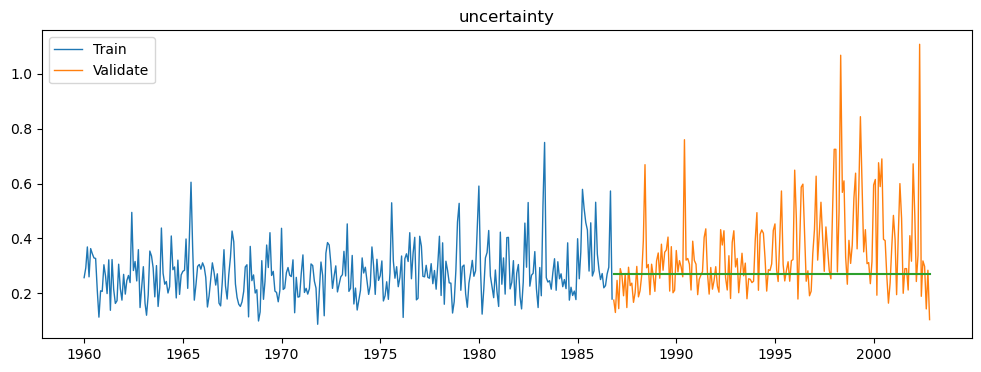

In [53]:
for col in train.columns:
    plot_and_eval(col)

# evaluate

In [54]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [55]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,uncertainty,0.0
2,simple_average,avg_temp,8.0
3,simple_average,uncertainty,0.0


# moving average

In [56]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

avg_temp = round(train['avg_temp'].rolling(period).mean().iloc[-1], 2)
uncertainty = round(train['uncertainty'].rolling(period).mean().iloc[-1], 2)

In [57]:
# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'avg_temp': [avg_temp],
                            'uncertainty': [uncertainty],
                           }, index = validate.index)
yhat_df.head(2)

,avg_temp,uncertainty
datetime,,
1986-11-01,12.04,0.32
1986-12-01,12.04,0.32


avg_temp -- RMSE: 8


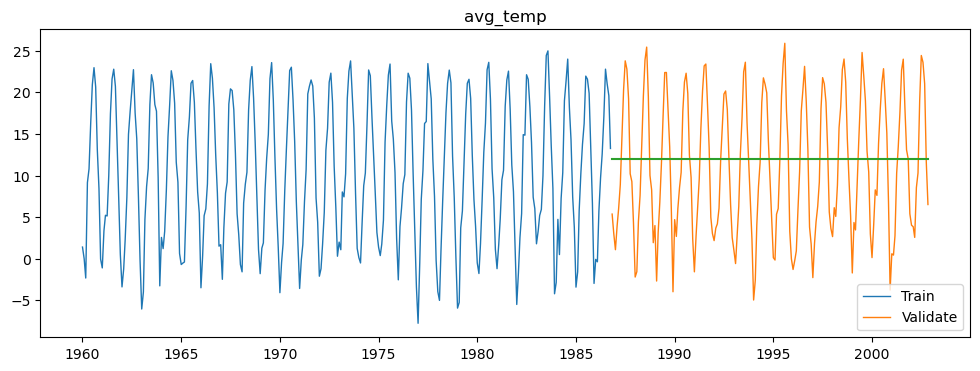

uncertainty -- RMSE: 0


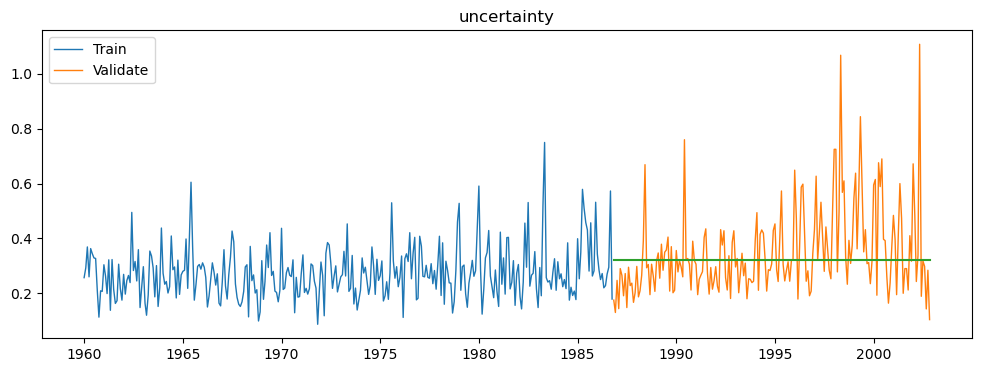

In [58]:
for col in train.columns:
    plot_and_eval(col)

# evaluate

In [59]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,uncertainty,0.0
2,simple_average,avg_temp,8.0
3,simple_average,uncertainty,0.0
4,30d moving average,avg_temp,8.0
5,30d moving average,uncertainty,0.0


In [60]:
train

,avg_temp,uncertainty
datetime,,
1960-01-01,1.402,0.257
1960-02-01,-0.008,0.293
1960-03-01,-2.318,0.369
1960-04-01,9.149,0.260
1960-05-01,10.803,0.363
...,...,...
1986-06-01,17.106,0.228
1986-07-01,22.787,0.270
1986-08-01,21.012,0.295


In [61]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    avg_temp = round(train['avg_temp'].rolling(p).mean().iloc[-1], 2)
    uncertainty = round(train['uncertainty'].rolling(p).mean().iloc[-1], 2)

    yhat_df = pd.DataFrame({'avg_temp': [avg_temp],
                            'uncertainty': [uncertainty],
                           }, index = validate.index)

    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'avg_temp'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'uncertainty'
                            )

In [62]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,uncertainty,0.0
2,simple_average,avg_temp,8.0
3,simple_average,uncertainty,0.0
4,30d moving average,avg_temp,8.0
5,30d moving average,uncertainty,0.0
6,1d moving average,avg_temp,8.0
7,1d moving average,uncertainty,0.0
8,4d moving average,avg_temp,12.0
9,4d moving average,uncertainty,0.0


In [63]:
# # get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,uncertainty,0.0
2,simple_average,avg_temp,8.0
3,simple_average,uncertainty,0.0
4,30d moving average,avg_temp,8.0
5,30d moving average,uncertainty,0.0
6,1d moving average,avg_temp,8.0
7,1d moving average,uncertainty,0.0
9,4d moving average,uncertainty,0.0
10,12d moving average,avg_temp,8.0


avg_temp 



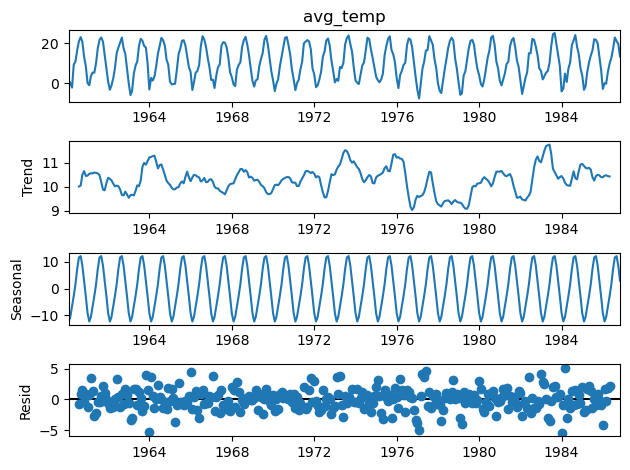

uncertainty 



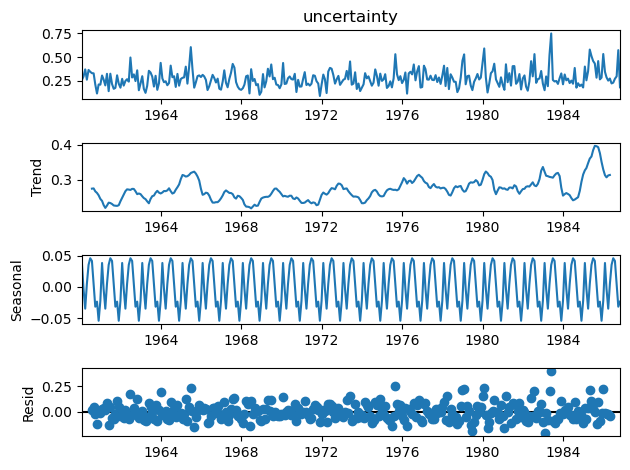

In [64]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('m').mean()).plot()
    plt.show()

# basic holt's linear trend

In [65]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

avg_temp -- RMSE: 29


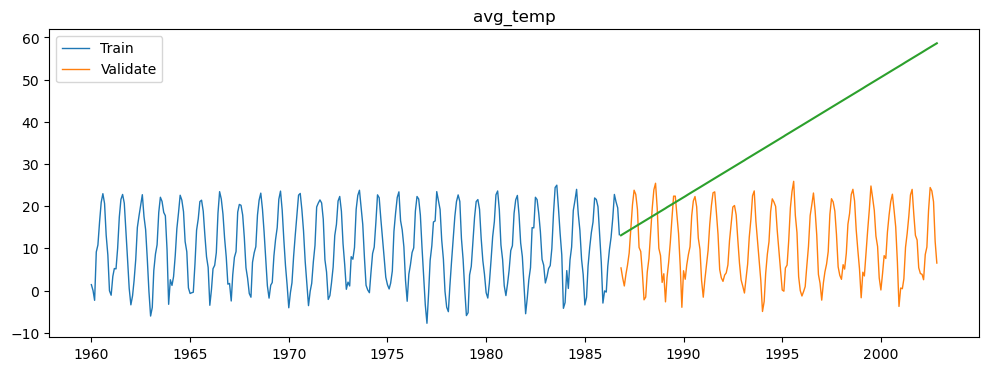

uncertainty -- RMSE: 0


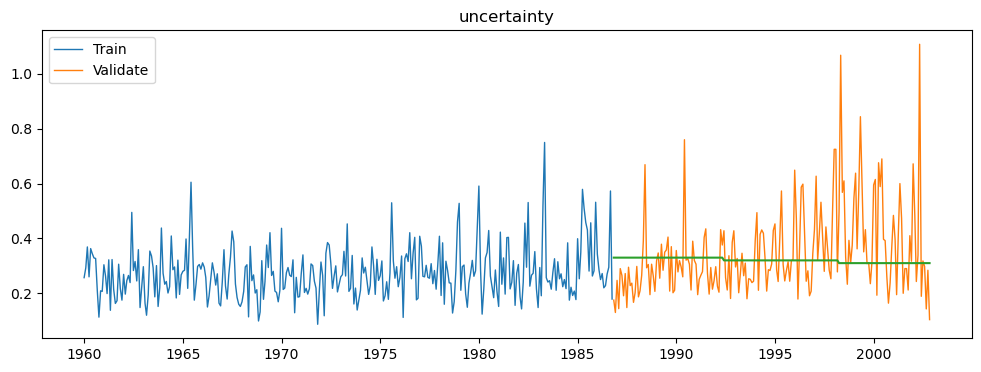

In [66]:
for col in train.columns:
    plot_and_eval(target_var = col)

# evaluate

In [67]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,uncertainty,0.0
2,simple_average,avg_temp,8.0
3,simple_average,uncertainty,0.0
4,30d moving average,avg_temp,8.0
5,30d moving average,uncertainty,0.0
6,1d moving average,avg_temp,8.0
7,1d moving average,uncertainty,0.0
8,4d moving average,avg_temp,12.0
9,4d moving average,uncertainty,0.0


In [68]:
# f

# resplit data


In [69]:
dfc.index.max()

Timestamp('2013-09-01 00:00:00')

In [70]:
dfc = dfc.drop(columns = ['wok','mon'])

In [71]:
train = dfc[:'2010'] # 2015
validate = dfc['2011'] # 2016
test = dfc['2012'] # 2017

# make predictions

In [72]:
train['2011']

KeyError: '2011'

In [ ]:
yhat_df = train['2011'] + train.diff(365).mean()

In [ ]:
pd.concat([yhat_df.head(1), validate.head(1)])

In [ ]:
yhat_df.index = validate.index

len(yhat_df)

In [ ]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)


In [ ]:
eval_df


In [73]:
# get the min rmse for each variable

min_avg_temp_rmse = eval_df.groupby('target_var')['rmse'].min()[0]
min_uncertainty_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_avg_temp_rmse) | 
         (eval_df.rmse == min_uncertainty_rmse)
        )]


,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,uncertainty,0.0
2,simple_average,avg_temp,8.0
3,simple_average,uncertainty,0.0
4,30d moving average,avg_temp,8.0
5,30d moving average,uncertainty,0.0
6,1d moving average,avg_temp,8.0
7,1d moving average,uncertainty,0.0
9,4d moving average,uncertainty,0.0
10,12d moving average,avg_temp,8.0


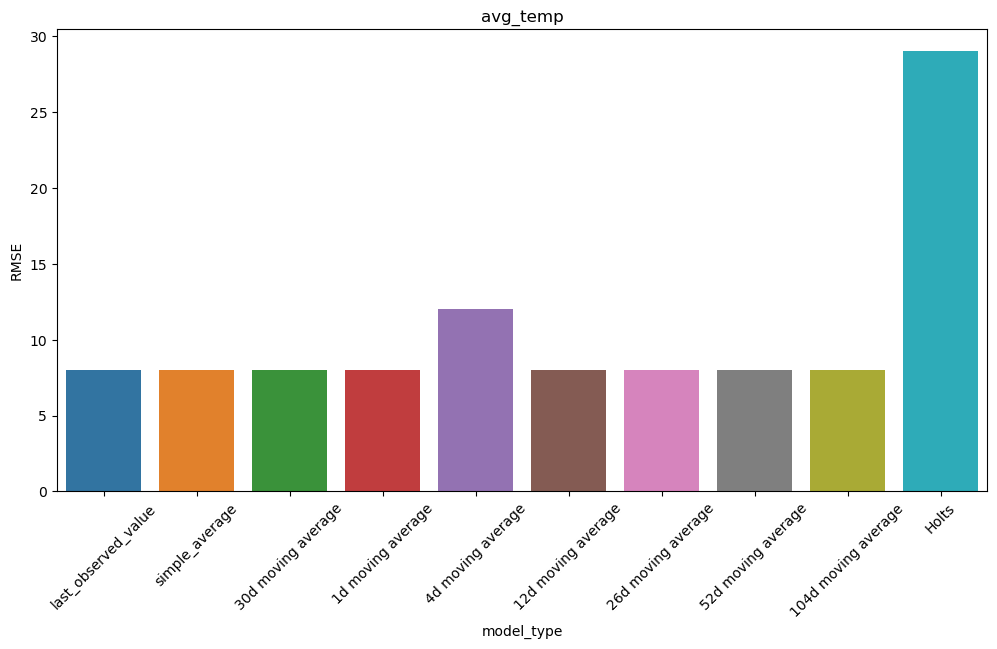

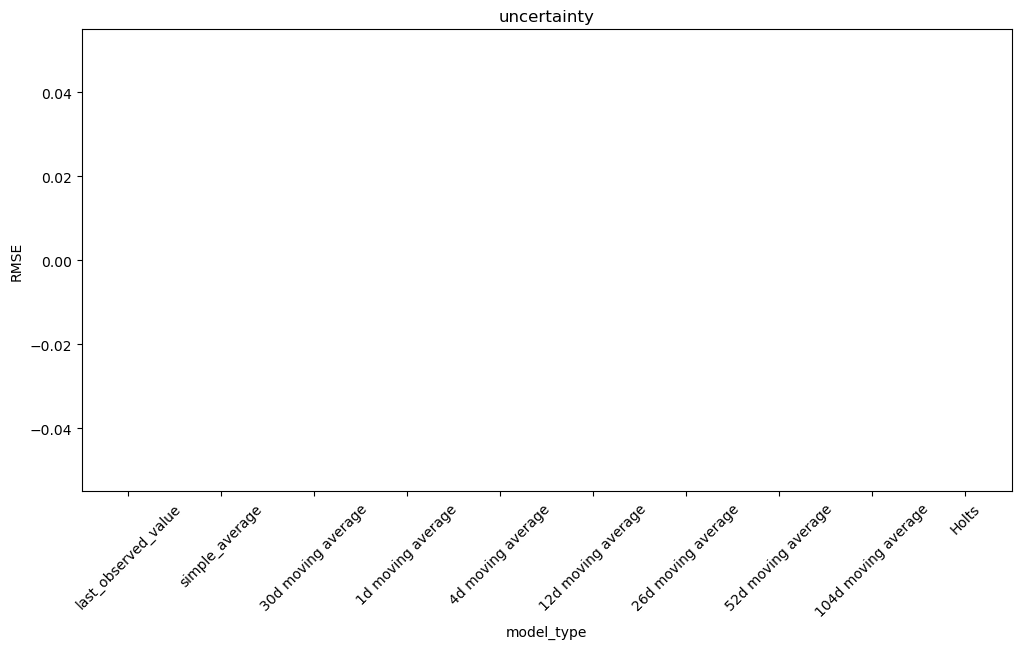

In [74]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x=x, y=y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [75]:
train

,avg_temp,uncertainty
datetime,,
1960-01-01,1.402,0.257
1960-02-01,-0.008,0.293
1960-03-01,-2.318,0.369
1960-04-01,9.149,0.260
1960-05-01,10.803,0.363
...,...,...
2010-08-01,24.948,0.360
2010-09-01,19.229,0.322
2010-10-01,14.582,0.241


In [76]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index


In [77]:
test

,avg_temp,uncertainty
datetime,,
2012-01-01,2.670,0.727
2012-02-01,3.698,0.567
2012-03-01,12.145,0.369
2012-04-01,8.383,0.347
2012-05-01,14.956,0.835
2012-06-01,19.532,0.519
2012-07-01,25.909,0.516
2012-08-01,22.778,0.420
2012-09-01,18.693,0.329


In [78]:
avg_temp = round(sqrt(mean_squared_error(test['avg_temp'], yhat_df['avg_temp'])), 0)
uncertainty = round(sqrt(mean_squared_error(test['uncertainty'], yhat_df['uncertainty'])), 0)


In [79]:
# Plot and evaluate train, validate, and test
def plot_and_eval_test(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5, color="red")
    plt.title(target_var)
    plt.legend()
    plt.show()

rmse - avg_temp:  3.0
rmse - uncertainty:  0.0


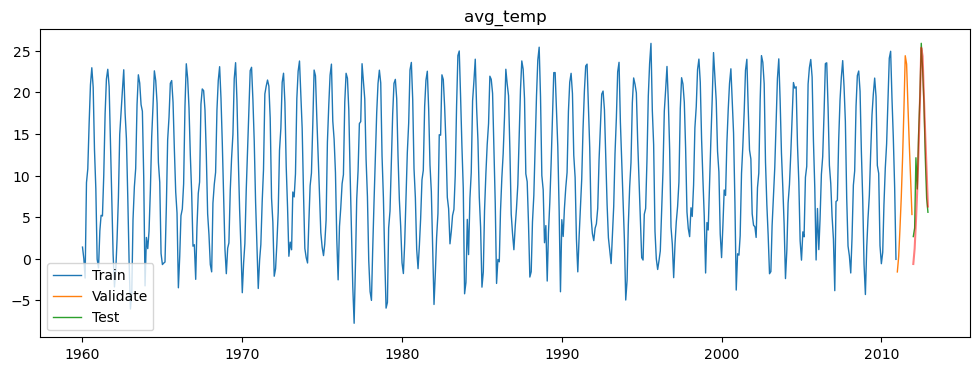

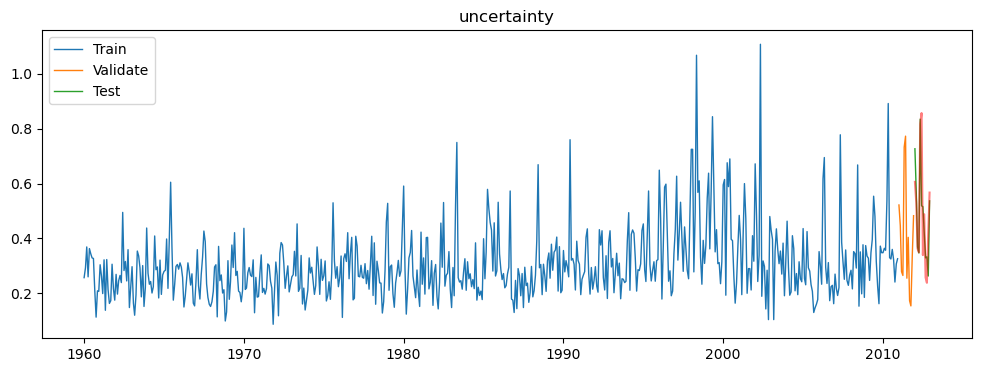

In [80]:
print("rmse - avg_temp: ", avg_temp )
print("rmse - uncertainty: ", uncertainty)

for col in train.columns:
    plot_and_eval_test(col)
